In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent.parent
ROOT_DIR = str(ROOT_PATH)
if ROOT_DIR not in sys.path:
    sys.path.insert(1, ROOT_DIR)
print(sys.path)

['C:\\Users\\jaakk\\code\\Impulcifer\\research\\reverberation-management', 'C:\\Users\\jaakk\\code\\Impulcifer', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\Scripts\\python37.zip', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\DLLs', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\lib', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\Scripts', 'c:\\users\\jaakk\\appdata\\local\\programs\\python\\python37\\Lib', 'c:\\users\\jaakk\\appdata\\local\\programs\\python\\python37\\DLLs', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv', '', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\lib\\site-packages', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\lib\\site-packages\\win32', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\lib\\site-packages\\win32\\lib', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\lib\\site-packages\\Pythonwin', 'C:\\Users\\jaakk\\code\\Impulcifer\\venv\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\jaakk\\.ipython']


In [94]:
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
from utils import read_wav, write_wav
from constants import HEXADECAGONAL_TRACK_ORDER, HESUVI_TRACK_ORDER, SPEAKER_NAMES
from impulse_response import ImpulseResponse
from impulse_response_estimator import ImpulseResponseEstimator
from hrir import HRIR

In [293]:
dir_path = ROOT_PATH.joinpath('data', 'demo')
estimator = ImpulseResponseEstimator.from_pickle(ROOT_PATH.joinpath('data', 'sweep-6.15s-48000Hz-32bit-2.93Hz-24000Hz.pkl'))
hrir = HRIR(estimator)
hrir.open_recording(dir_path.joinpath('FL,FR.wav'), ['FL', 'FR'])
ir = hrir.irs['FL']['left']
ir.crop_head()
ir.data /= np.max(np.abs(ir.data))

In [294]:
envelope = abs(ir.data)
envelope = 20 * np.log10(envelope / np.max(envelope))
hilbert = np.imag(signal.hilbert(ir.data))
hilbert_envelope = abs(hilbert)
hilbert_envelope = 20 * np.log10(hilbert_envelope / np.max(hilbert_envelope))
t = np.arange(0, 1 / ir.fs * len(ir), 1 / ir.fs)

In [296]:
#def knee_point(ir):

# 1. The squared impulse response is averaged into localtime intervals in the range of 10–50 ms,
# to yield asmooth curve without losing short decays.
squared = 10 * np.log10(ir.data ** 2)  # Square data
wd = 0.03  # Window duration
n = int(ir.duration() / wd)  # Number of time windows
w = int(len(ir) / n)  # Width of a single time window
t_windows = np.arange(n) * wd + wd / 2
windows = squared.copy()
windows = np.reshape(windows[:n*w], (n, w))  # Split into time windows
windows = np.mean(windows, axis=1)  # Average each time window

# 2. A first estimate for the background noise level is deter-mined  from a time segment containing the last 10  %of the impulse response.
# This gives a reasonable statis-tical selection without a large systematic error, if thedecay continues to the end of the response.
tail = squared[int(-0.1 * len(squared)):]
noise_floor = np.mean(tail)
print(f'Noise floor: {noise_floor}')

# 3. The decay slope is estimated using linear regression between the time interval containing the response 0 dBpeak,
# and  the  first interval 5–10 dB above the  background noise level.
slope_end = np.argwhere(windows >= noise_floor + 10)[-1, 0]
slope, intercept, _, _, _ = stats.linregress(t_windows[:slope_end], windows[:slope_end])

# 4. A preliminary crosspoint is determined at the intersection of the decay slope and the background noise level.
crosspoint_time = (noise_floor - intercept) / slope
print(f'Crosspoint {crosspoint_time}')
crosspoint_index = np.argwhere(t_windows >= crosspoint_time)[0, 0]  # Index of first window which comes after slope end time

Noise floor: -108.77060599120469
Crosspoint 0.4713908690022172


In [297]:
# 5. A new time interval length is calculated according tothe calculated slope, so that there are 3–10 intervalsper 10 dB of decay.
wd = 10 / (abs(slope) * 3)
n = int(ir.duration() / wd)  # Number of time windows
w = int(len(ir) / n)  # Width of a single time window
t_windows = np.arange(n) * wd + wd / 2

# 6. The squared impulse is averaged into the new local timeintervals.
windows = squared.copy()
windows = np.reshape(windows[:n*w], (n, w))  # Split into time windows
windows = np.mean(windows, axis=1)  # Average each time window

# Steps 7–9 are iterated until the crosspoint is found to converge(max. 5 iterations).
for _ in range(5):
    # 7. The background noise level is determined again. The evaluated noise segment should start from a point
    # corresponding to 5–10 dB of decay after the crosspoint, or a minimum of 10 % of the total response length.
    crosspoint_index = np.argwhere(t_windows >= crosspoint_time)[0, 0]
    crosspoint_value = windows[crosspoint_index]
    noise_floor_start_index = np.argwhere(windows <= crosspoint_value - 5)[0, 0]  # Index to the first window which is 5 dB below crosspoint
    #noise_floor_start_time = max(t_windows[noise_floor_start_index], 0.1 * ir.duration())  # Discovered index or 10% of total IR length
    noise_floor_start_time = t_windows[noise_floor_start_index]  # Discovered index or 10% of total IR length
    noise_floor_end_time = noise_floor_start_time + 0.1 * ir.duration()  # TODO: Until the very end?
    noise_floor = np.mean(squared[np.logical_and(t >= noise_floor_start_time, t <= noise_floor_end_time)])
    print(f'Noise floor: {noise_floor}')
    
    # 8. The late decay slope is estimated for a dynamic range of 10–20 dB, starting from a point 5–10 dB above the noise level.
    slope_end = np.argwhere(windows >= noise_floor + 8)[-1, 0]
    slope_start = np.argwhere(windows >= noise_floor + 28)[-1, 0]
    late_slope, late_intercept, _, _, _ = stats.linregress(t_windows[slope_start:slope_end], windows[slope_start:slope_end])
    print(f'{slope_start} -> {slope_end}: {late_slope:.1f}t + {late_intercept:.2f}')
    
    # 9. A new crosspoint is found.
    crosspoint_time = (noise_floor - late_intercept) / late_slope
    print(f'Crosspoint {crosspoint_time}')
    new_crosspoint_index = np.argwhere(t_windows >= crosspoint_time)[0, 0]  # Index of first window which comes after slope end time
    if new_crosspoint_index == crosspoint_index:
        # Converged
        break

#return windows, noise_floor

Noise floor: -104.37311399460823
11 -> 18: -126.7t + -44.76
Crosspoint 0.4706632305311982


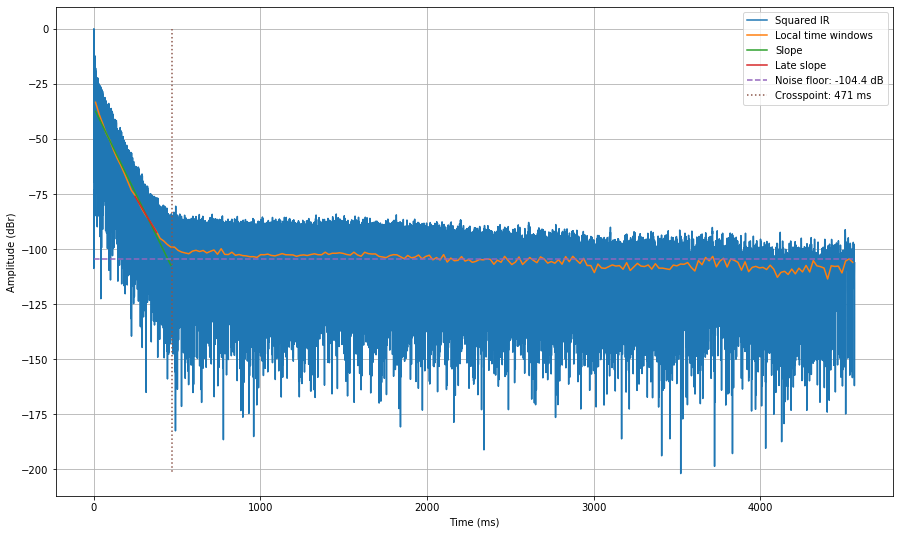

In [304]:
#windows, noise_floor = knee_point(ir)
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
ax.plot(t * 1000, squared, label='Squared IR')
ax.plot(t_windows * 1000, windows, label='Local time windows')
ax.plot(t_windows[:crosspoint_index] * 1000, t_windows[:crosspoint_index] * slope + intercept, label='Slope')
ax.plot(t_windows[slope_start:slope_end] * 1000, t_windows[slope_start:slope_end] * late_slope + late_intercept, label='Late slope')
ax.plot([0, t_windows[-1] * 1000], [noise_floor, noise_floor], linestyle='--', label=f'Noise floor: {noise_floor:.1f} dB')
ax.plot(np.array([crosspoint_time, crosspoint_time]) * 1000, [0, np.min(squared)], linestyle='dotted', label=f'Crosspoint: {crosspoint_time * 1000:.0f} ms')
ax.grid()
ax.legend(loc='upper right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Amplitude (dBr)')
plt.show()